
## Introduction

The Seasonal Autoregressive Integrated Moving Average (SARIMA) model is an extension of the ARIMA model (discussed in the [previous article](/posts/finance/stock_prediction/arima/)) that incorporates seasonality. This makes it particularly useful for analyzing financial time series data, which often exhibits both trend and seasonal patterns. In this article, we'll apply the SARIMA model to Apple (AAPL) stock data, perform signal decomposition, and provide a detailed mathematical explanation of the model.

## 1. Data Preparation and Exploration

First, let's obtain the Apple stock data and prepare it for analysis:

[*********************100%%**********************]  1 of 1 completed


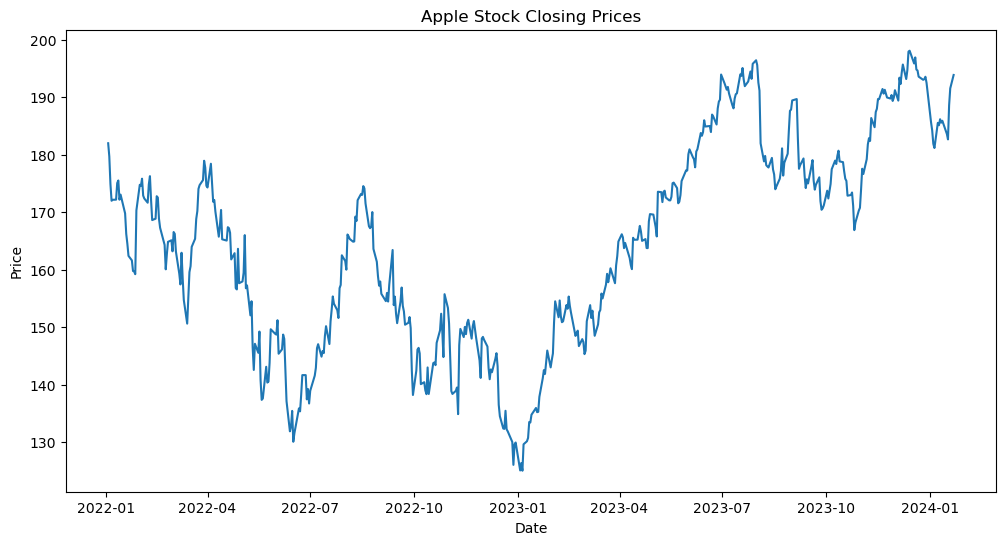

(Date
 2022-01-03    182.009995
 2022-01-04    179.699997
 2022-01-05    174.919998
 2022-01-06    172.000000
 2022-01-07    172.169998
 Name: Close, dtype: float64,
 Date
 2022-01-03    182.009995
 2022-01-04    179.699997
 2022-01-05    174.919998
 2022-01-06    172.000000
 2022-01-07    172.169998
 Name: Close, dtype: float64)

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from pmdarima import auto_arima
import seaborn as sns


# Download Apple stock data
ticker = "AAPL"
start_date = "2022-01-01"
end_date = "2024-01-23"
data = yf.download(ticker, start=start_date, end=end_date)
df = data.copy()

# Use closing prices for our analysis
ts = data['Close'].dropna()

# Plot the time series
plt.figure(figsize=(12,6))
plt.plot(ts)
plt.title('Apple Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

ts.head(), data['Close'].head()

## 2. Signal Decomposition

Before we build our SARIMA model, it's crucial to understand the components of our time series. We'll use seasonal decomposition to break down the series into trend, seasonal, and residual components:



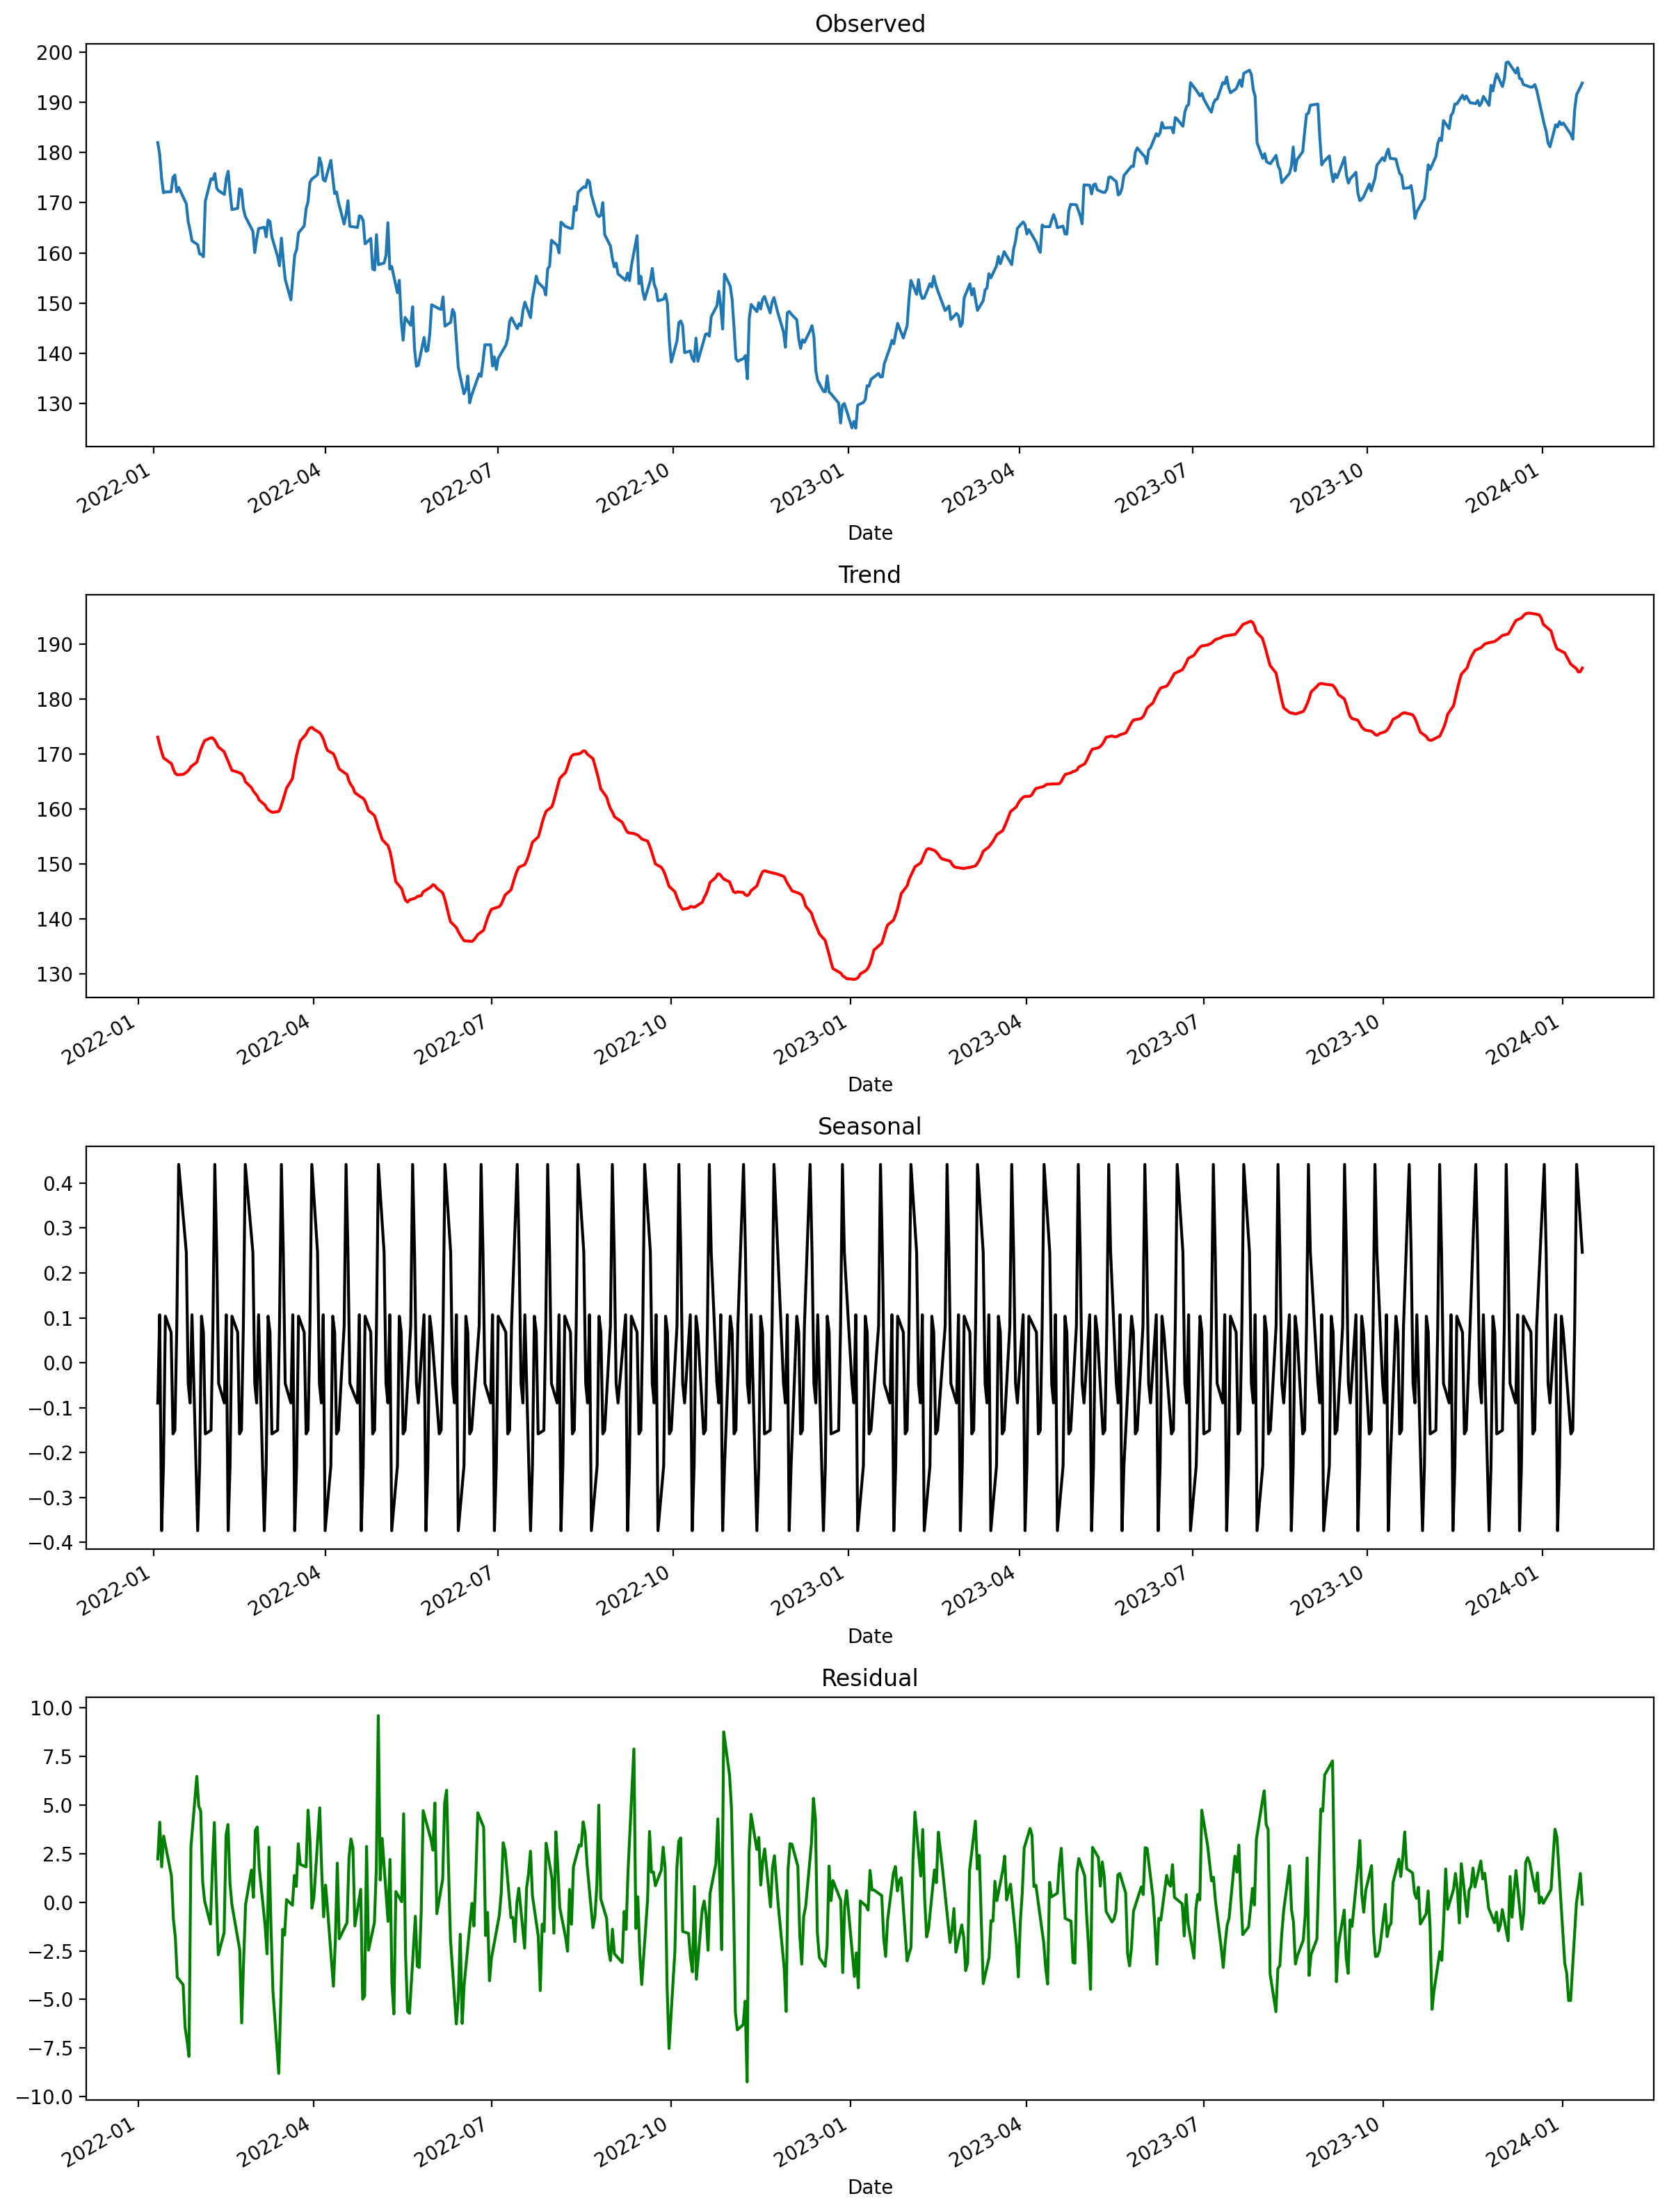

In [2]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(ts, model='additive', period=12)  # 252 trading days in a year
plt.rcParams.update({'figure.dpi':200})

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2, c='r')
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3, c='k')
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4, c='g')
ax4.set_title('Residual')
plt.tight_layout()
plt.show()




This decomposition helps us understand:
1. **Trend**: The long-term progression of the series
2. **Seasonality**: Repeating patterns or cycles
3. **Residual**: The noise left after accounting for trend and seasonality

## 3. Mathematical Formulation of SARIMA

The SARIMA model is denoted as SARIMA(p,d,q)(P,D,Q)m, where:
- p, d, q: Non-seasonal orders of AR, differencing, and MA
- P, D, Q: Seasonal orders of AR, differencing, and MA
- m: Number of periods per season

The mathematical formulation of SARIMA combines the non-seasonal and seasonal components:

1. **Non-seasonal components**:
   - $AR(p): φ(B) = 1 - φ₁B - φ₂B² - ... - φₚBᵖ$
   - $MA(q): θ(B) = 1 + θ₁B + θ₂B² + ... + θ_qBq$

2. **Seasonal components**:
   - $SAR(P): Φ(Bᵐ) = 1 - Φ₁Bᵐ - Φ₂B²ᵐ - ... - Φ_PBᴾᵐ$
   - $SMA(Q): Θ(Bᵐ) = 1 + Θ₁Bᵐ + Θ₂B²ᵐ + ... + Θ_QBQᵐ$

3. **Differencing**:
   - Non-seasonal: $(1-B)ᵈ$
   - Seasonal: $(1-Bᵐ)D$

The complete SARIMA model can be written as:

$$φ(B)Φ(Bᵐ)(1-B)ᵈ(1-Bᵐ)D Yₜ = θ(B)Θ(Bᵐ)εₜ$$

Where:
- B is the backshift operator ($BYₜ = Yₜ₋₁$)
- Yₜ is the time series
- εₜ is white noise

## 4. SARIMA Model Implementation

Now that we understand the components and mathematical formulation, let's implement the SARIMA model:
From the previous article we found that the best *(p,d,q)*



In [3]:
from pmdarima.arima.utils import nsdiffs
D = nsdiffs(ts,
            m=12,  # commonly requires knowledge of dataset
            max_D=12,
            )  # -> 0
D

0

In [4]:
# Create Training and Test
train = ts[:int(len(df)*0.8)]
test = ts[int(len(df)*0.8):]

In [5]:
def grid_search_sarima(train, test, p_range, d_range, q_range, P_range, D_range, Q_range, m_range):
    best_aic = float('inf')
    best_mape = float('inf')
    best_order = None
    for p in p_range:
        for d in d_range:
            for q in q_range:
                for P in P_range:
                    for D in D_range:
                        for Q in Q_range:
                            for m in m_range:
                                try:
                                    model = SARIMAX(train.values, order=(p,d,q), seasonal_order=(P,D,Q,m))
                                    results = model.fit()
                                    fc_series = pd.Series(results.forecast(steps=len(test)), index=test.index)  # 95% conf
                                    test_metrics = forecast_accuracy(fc_series.values, test.values)
                                    # if results.aic < best_aic:
                                    #     best_aic = results.aic
                                    #     best_order = (p,d,q)
                                    # print(f"(p,d,q)=({p},{d},{q}) | (P,D,Q,m)=({P},{D},{Q},{m})", test_metrics['mape'])
                                    if test_metrics['mape'] < best_mape:
                                        best_mape = test_metrics['mape']
                                        best_order = (p,d,q)
                                        best_sorder = (P,D,Q,m)
                                        print("temp best:" + f"(p,d,q)=({p},{d},{q}) | (P,D,Q,m)=({P},{D},{Q},{m})", 
                                            round(test_metrics['mape'], 4))
                                except Exception as e:
                                    print(e)
                                    continue
    return best_order, best_sorder


# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))    # MAPE
    me = np.mean(forecast - actual)                             # ME
    mae = np.mean(np.abs(forecast - actual))                    # MAE
    mpe = np.mean((forecast - actual)/actual)                   # MPE
    rmse = np.mean((forecast - actual)**2)**.5                  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]                   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)                             # minmax
    acf1 = acf(forecast-test)[1]                                # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [34]:

# Determine optimal SARIMA parameters
# model = auto_arima(ts, seasonal=True, m=12,
#                     start_p=0, start_q=0, start_P=1, start_Q=1,
#                     max_p=4, max_q=4, max_P=2, max_Q=2, d=1, D=1,
#                     trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, out_of_sample=len(test))

# print(model.summary())

# Custom Grid Search
# d = 1 # from 
# best_order, best_sorder = grid_search_sarima(train, test, range(0,3), [d], range(0,3), range(3), [D], range(3), [4, 8, 12])
# print(f"Best ARIMA order based on grid search: {best_order}")

# Fit the SARIMA model
# sarima_model = SARIMAX(ts, order=model.order, seasonal_order=model.seasonal_order) (2,1,2) | (P,D,Q,m)=(2,1,1,
# sarima_model = SARIMAX(train, order=best_order, seasonal_order=best_sorder) #(2,1,2) | (P,D,Q,m)=(2,1,1,8)
# print(best_order, best_sorder)
# sarima_model = SARIMAX(train, order=(2,1,2), seasonal_order=(6,0,6,8))
sarima_model = SARIMAX(train, order=(2,1,2), seasonal_order=(2,2,1,8))
results = sarima_model.fit()

print(results.summary())

c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                  412
Model:             SARIMAX(2, 1, 2)x(2, 2, [1], 8)   Log Likelihood               -1073.473
Date:                             Fri, 05 Jul 2024   AIC                           2162.947
Time:                                     20:16:14   BIC                           2194.778
Sample:                                          0   HQIC                          2175.558
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0464      0.051      0.902      0.367      -0.054       0.147
ar.L2          0.8356      

c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


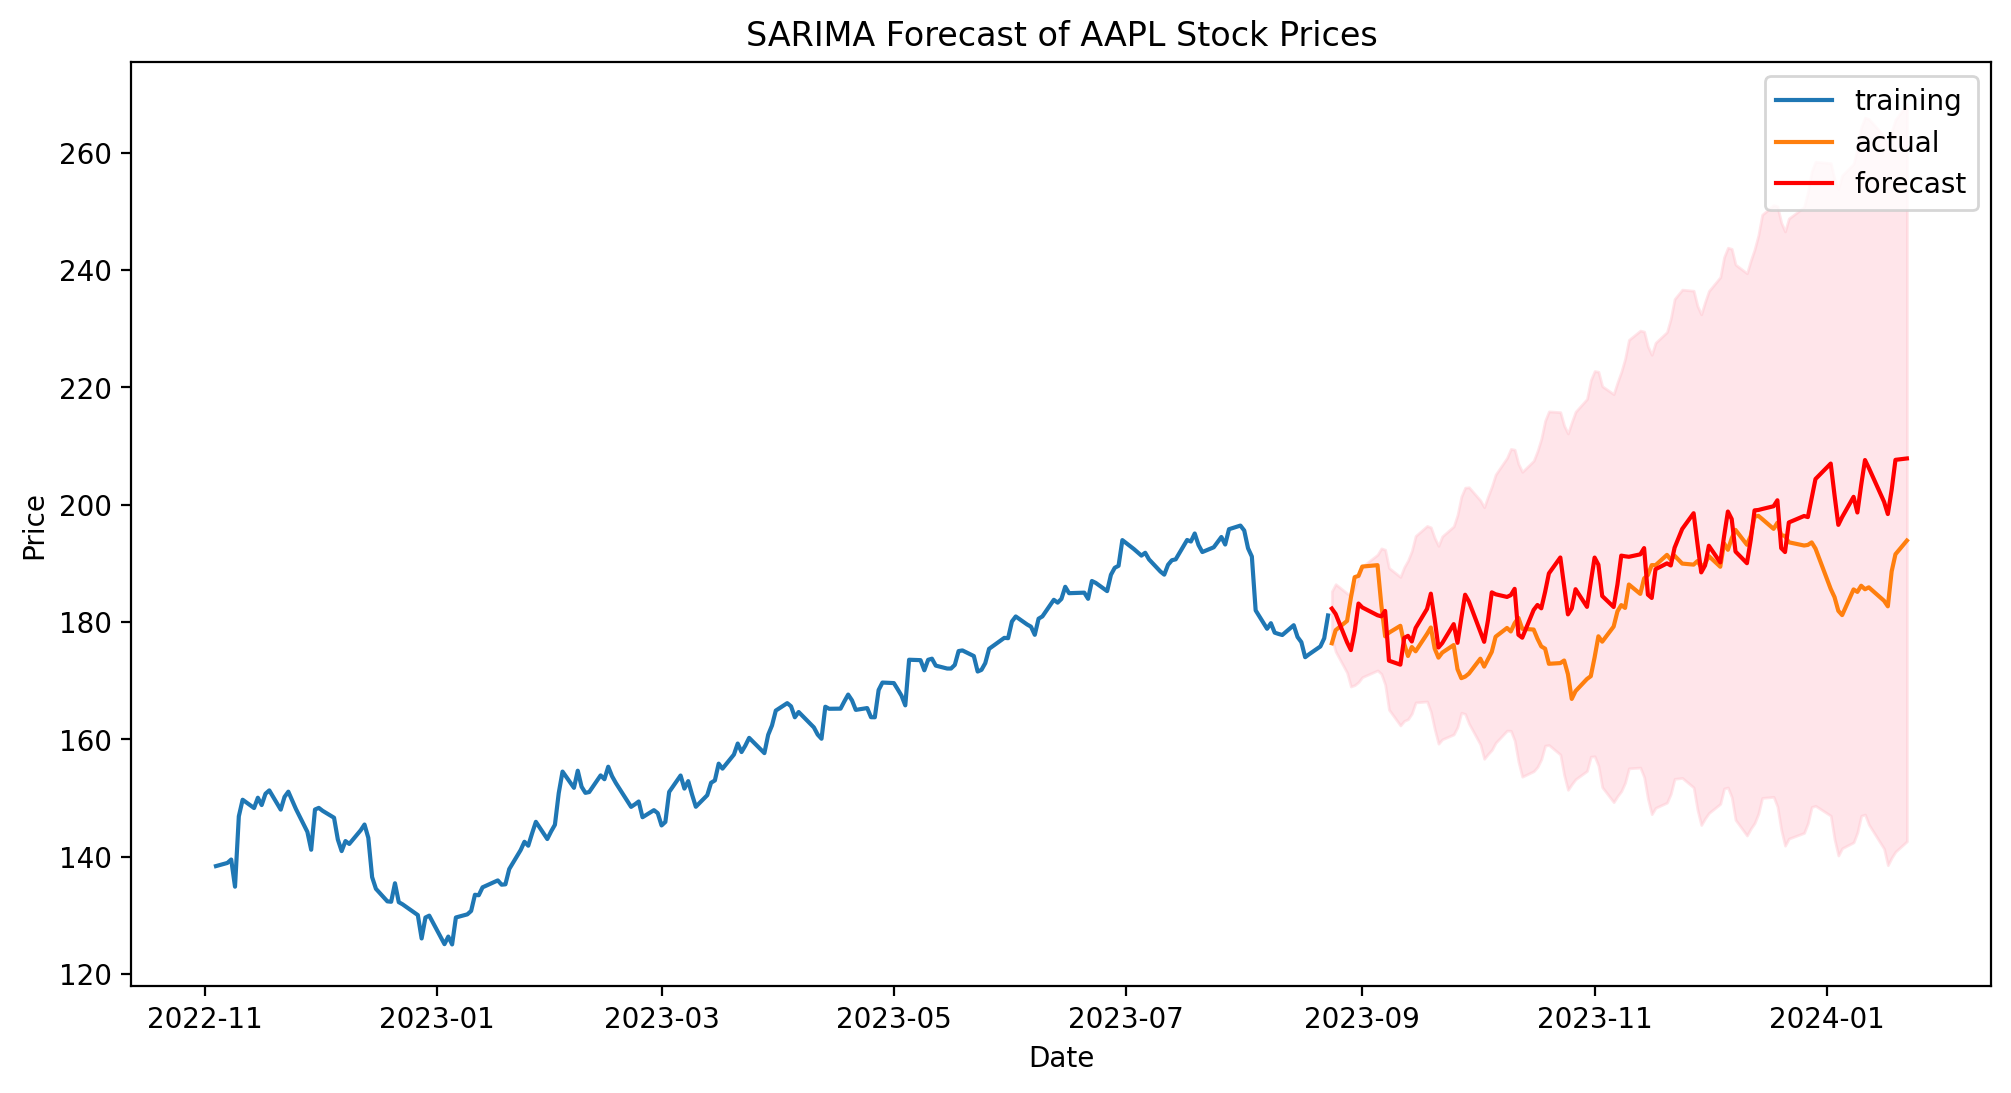

In [36]:
# sarima_model = SARIMAX(train, order=(2,1,2), seasonal_order=(2,2,1,8))
# results = sarima_model.fit()


# Forecast
forecast_steps = len(test) # Forecast for one year
forecast = results.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int(alpha=0.25)
# forecast_index = pd.date_range(start=test.index[0]+pd.Timedelta(24, 'hours'), periods=len(forecast_ci))
forecast_index = test.index

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train[-200:], label='training')
# plt.plot(ts.index, ts, label='Observed')
plt.plot(test, label='actual')
plt.plot(forecast_index, forecast.predicted_mean + decomposition.seasonal[test.index].values*10, color='r', label='forecast')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.4)
plt.title(f'SARIMA Forecast of {ticker} Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [33]:
# forec_temp = pd.DataFrame(forecast.predicted_mean)
# forec_temp.index = forecast_index
# pd.DataFrame(pd.DataFrame(decomposition.seasonal[test.index]).values + forec_temp.values).plot()

## 5. Model Diagnostics

After fitting the model, it's important to check its adequacy:
 

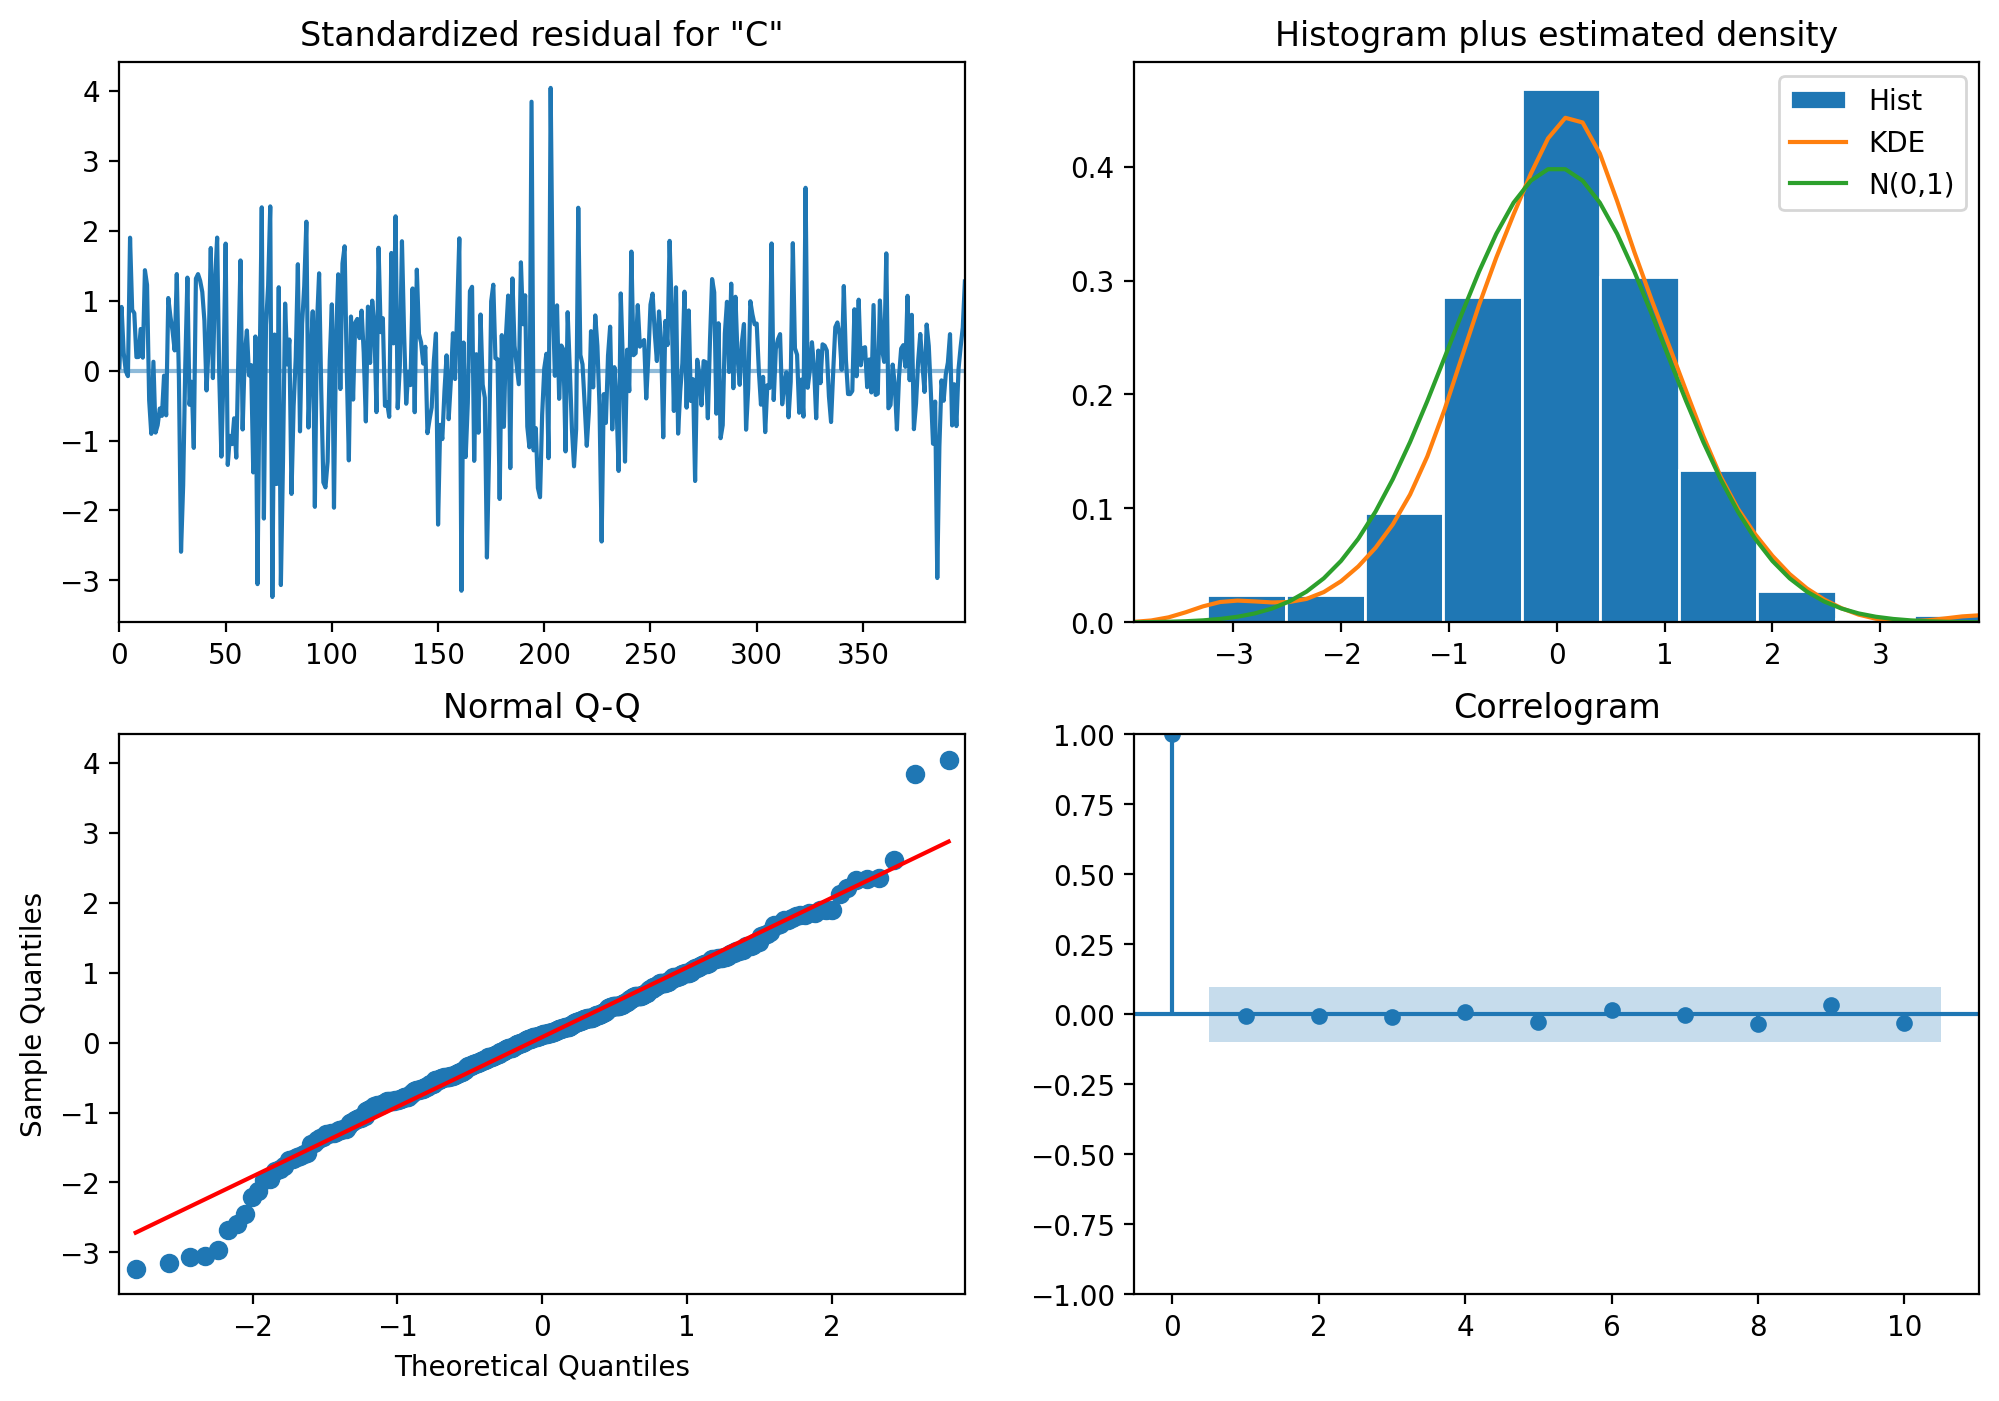

In [ ]:
# Model diagnostics
results.plot_diagnostics(figsize=(12, 8))
plt.show()

These diagnostic plots help us check for:
1. **Standardized residual**: Should resemble white noise
2. **Histogram plus KDE**: Should be normally distributed
3. **Q-Q plot**: Should follow the straight line
4. **Correlogram**: Should show no significant autocorrelation

## Conclusion

The SARIMA model provides a powerful tool for analyzing and forecasting time series data with both trend and seasonal components. By decomposing the Apple stock price series and applying a SARIMA model, we've gained insights into the underlying patterns and potential future movements of the stock.

Key takeaways:
1. Signal decomposition revealed clear trend and seasonal components in Apple's stock price.
2. The SARIMA model captures both non-seasonal and seasonal patterns in the data.
3. Model diagnostics are crucial for ensuring the validity of our forecasts.

Remember that while these models can provide valuable insights, stock prices are influenced by many external factors not captured in historical data alone. Always combine statistical analysis with fundamental research and an understanding of market conditions when making investment decisions.